In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import nltk
from transformers import BertTokenizer

# Check GPU Utility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [2]:
tweets = pd.read_csv("data/cleaned/nohashtag_cleaned_lemmatized_english.csv")
tweets.head()

,Unnamed: 0,tweet_text,cyberbullying_type,lang,mentioned_users,hashtags
0,0,word food crapilicious,not_cyberbullying,en,NaN,katandandre mkr
1,1,white,not_cyberbullying,en,NaN,aussietv MKR theblock ImACelebrityAU today sun...
2,2,@username classy whore red velvet cupcake,not_cyberbullying,en,XochitlSuckkks,NaN
3,3,@username meh p thanks head concern angry dude...,not_cyberbullying,en,Jason_Gio,NaN
4,4,@username isi account pretend kurdish account ...,not_cyberbullying,en,RudhoeEnglish,NaN


In [3]:
tweets = tweets.drop('Unnamed: 0', axis = 1)

In [4]:
tweets.shape

(44660, 5)

In [5]:
tweets.isna().sum()

tweet_text               26
cyberbullying_type        0
lang                      0
mentioned_users       28106
hashtags              38160
dtype: int64

In [6]:
tweets['tweet_text'] = tweets['tweet_text'].fillna('<UNK>')
tweets['tweet_text'] = tweets['tweet_text'].replace('nan', '<UNK>')
tweets['hashtags'] = tweets['hashtags'].fillna('<NO_HASHTAG>')
tweets['mentioned_users'] = tweets['mentioned_users'].fillna('<NO_mentioned_users>')

In [7]:
tweets.isna().sum()

tweet_text            0
cyberbullying_type    0
lang                  0
mentioned_users       0
hashtags              0
dtype: int64

In [8]:
tweets.columns

Index(['tweet_text', 'cyberbullying_type', 'lang', 'mentioned_users',
       'hashtags'],
      dtype='object')

In [9]:
tweets.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [10]:
tweets['cyberbullying_type'] = tweets['cyberbullying_type'].astype('category')

In [11]:
train_data, test_data = train_test_split(tweets, test_size = 0.2, random_state = 20)
train_data, val_data = train_test_split(train_data, test_size = 0.25, random_state = 20)

In [58]:
label_to_int = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

class TweetDataset(Dataset):
    def __init__(self, data, tokenizer, max_len = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_text = self.data.iloc[idx]['tweet_text'] 
        label = label_to_int[self.data.iloc[idx]['cyberbullying_type']]
        try:
            encoding = self.tokenizer.encode_plus(input_text, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        except Exception as e:
            print(f"Error at idx={idx}, input_text='{input_text}': {e}")
            raise e
        return{
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label':torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(train_data, tokenizer)
val_dataset = TweetDataset(val_data, tokenizer)
test_dataset = TweetDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [13]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        #Used GRU as it is faster to train than LSTM and solves the vanishing gradient problem
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional=bidirectional, dropout = dropout, batch_first = True)
        if bidirectional:
            input_dim = hidden_dim * 2
        else:
            input_dim = hidden_dim
        self.fc = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        #print(embedded)
        output, hidden = self.rnn(embedded)
        
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        logits = self.fc(hidden)
        return logits.view(x.size(0), -1)
        

In [14]:
#Hyperparameters:
VOCAB_SIZE = len(tokenizer.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = len(np.unique(tweets['cyberbullying_type']))
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.4
#BATCH_SIZE = 32

In [15]:
model = RNNClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, N_LAYERS, BIDIRECTIONAL, DROPOUT).to(device)

optimizer = optim.Adam(model.parameters()) #Using Adam Optimizer
criterion = nn.CrossEntropyLoss().to(device) #Using CrossEntropyLoss function


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    
    #model.train()
    
    for batch in iterator:
        optimizer.zero_grad() #Clears the gradients of all optimized model parameters before calculating the next backward pass
        input_ids = batch['input_ids'].to(device)
        #print(input_ids)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].view(-1).to(device)
        
        with torch.cuda.amp.autocast():
            predictions = model(input_ids)
            loss = criterion(predictions, labels) 
        #print(predictions.argmax(1))
        accuracy = (predictions.argmax(1) == labels).float().mean()
        
        loss.backward() #Computes the gradients of the loss with respect to model parameters 
        optimizer.step() #updates the parameters using the optimizer.
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy / len(iterator) #Calculates loss and accuracy across all batches in the epoch, and returns them as a tuple.
    

In [16]:
def evaluate(model, iterator,criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    
    #model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            predictions = model(input_ids)
        
            loss = criterion(predictions, labels)
            #print(loss.item())
            accuracy = (predictions.argmax(1) == labels).float().mean()
        
            epoch_loss += loss.item()
            #print(epoch_loss)
            epoch_accuracy += accuracy.item()
        
    return epoch_loss / len(iterator), epoch_accuracy  / len(iterator)

In [65]:
def evaluate_matrix(model, iterator):
    epoch_loss = 0
    epoch_accuracy = 0
    #prediction_list = []
    #label_list = []
    pred_vec = np.zeros((len(iterator), 32))
    label_vec = np.zeros((len(iterator), 32))
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].numpy()
            predictions = model(input_ids).argmax(1).cpu().numpy()
            #print(predictions)
            #print(i)
            pred_vec[i] = predictions
            label_vec[i] = labels
        
    return pred_vec, label_vec

In [17]:
EPOCHS = 5

total_training_loss = np.zeros(EPOCHS)
total_testing_loss = np.zeros(EPOCHS)

for i, epoch in enumerate(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    # Append loss to vector for graphing
    total_training_loss[i] = train_loss
    total_testing_loss[i] = test_loss
    
    if epoch % 1 == 0:
        print(f'Epoch: {epoch}')
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')
        print('----------------------------------------')

#test_loss, test_acc = evaluate(model, test_loader, criterion)
#print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Epoch: 0
Train Loss: 0.648 | Train Acc: 72.07%
Test Loss: 0.500 | Test Acc: 78.65%
----------------------------------------
Epoch: 1
Train Loss: 0.451 | Train Acc: 80.30%
Test Loss: 0.460 | Test Acc: 80.00%
----------------------------------------
Epoch: 2
Train Loss: 0.410 | Train Acc: 82.16%
Test Loss: 0.454 | Test Acc: 80.70%
----------------------------------------
Epoch: 3
Train Loss: 0.382 | Train Acc: 83.55%
Test Loss: 0.442 | Test Acc: 81.13%
----------------------------------------
Epoch: 4
Train Loss: 0.361 | Train Acc: 84.73%
Test Loss: 0.438 | Test Acc: 81.70%
----------------------------------------


In [64]:
preds, labels = evaluate_matrix(model, test_loader)

[1 4 3 2 2 2 3 2 0 2 2 4 1 4 2 2 3 3 3 1 0 1 1 1 1 2 1 4 3 0 4 5]
[4 1 2 5 5 2 3 4 4 0 5 5 3 2 1 5 3 1 1 2 0 3 4 5 2 4 3 2 5 1 1 2]
[2 1 2 2 4 0 4 0 0 0 5 0 1 5 4 1 2 0 5 0 3 2 2 3 4 3 2 0 5 4 1 1]
[4 4 2 2 1 4 3 4 1 3 2 2 5 0 4 4 3 0 0 4 4 3 0 4 3 5 5 3 4 2 1 1]
[1 0 2 1 3 2 1 3 1 4 1 3 5 3 5 0 4 2 5 4 4 2 5 4 4 0 5 3 0 1 1 4]
[0 4 2 4 4 1 5 1 2 4 0 3 5 2 2 2 3 0 3 0 0 1 2 1 4 2 1 3 1 3 1 0]
[2 1 2 4 3 1 3 1 1 5 4 1 0 5 5 3 1 2 0 3 2 5 4 4 2 2 1 0 0 5 2 2]
[3 4 4 0 3 2 1 0 2 2 0 4 4 4 2 0 4 4 5 4 5 4 4 2 5 1 3 0 4 1 3 5]
[2 1 5 2 4 4 2 0 5 1 3 5 5 0 2 0 3 0 3 3 0 1 1 5 5 4 4 0 3 5 3 1]
[2 5 1 0 4 5 3 3 5 5 5 5 1 4 1 1 0 1 5 2 0 3 3 5 1 4 5 2 1 5 4 2]
[2 1 2 1 1 4 2 5 2 1 4 4 0 1 2 0 3 1 3 2 0 0 0 2 4 4 0 5 1 5 2 4]
[2 4 1 4 5 1 1 1 4 3 0 4 4 0 3 0 5 4 5 1 1 4 5 3 0 5 4 2 5 5 2 4]
[2 3 0 1 5 4 3 4 2 3 0 1 3 0 5 2 4 1 3 0 4 4 2 1 1 4 1 0 2 2 5 1]
[4 2 4 1 2 5 3 4 5 4 0 4 1 0 2 3 4 4 0 1 0 2 1 2 0 1 0 2 0 3 1 3]
[1 0 3 1 5 3 5 5 2 3 1 1 1 4 0 2 3 2 3 5 3 2 3 5 1 2 0 1 1 5 3 3]
[5 0 2 5 4

[2 3 4 3 4 1 2 5 0 2 1 2 4 5 5 5 0 0 2 2 5 4 2 5 5 4 0 0 5 4 4 4]
[2 2 1 1 4 4 5 4 0 2 1 0 2 2 0 2 0 5 3 3 2 0 0 2 4 4 5 4 2 0 3 3]
[2 4 1 3 5 1 4 1 5 5 5 0 2 0 4 2 0 5 4 3 3 2 2 2 3 2 5 0 0 0 1 1]
[4 3 3 1 3 4 1 3 1 5 3 1 2 0 3 4 5 3 5 1 0 2 5 4 3 0 3 3 0 0 3 1]
[0 4 0 4 4 2 2 5 1 1 5 2 4 3 0 3 4 5 0 5 2 1 2 5 4 3 1 2 2 2 4 2]
[2 0 1 4 4 0 0 2 3 4 3 3 0 1 3 1 1 2 0 4 0 5 3 2 5 2 5 0 1 2 1 5]
[2 5 0 4 5 3 0 3 5 3 3 0 0 0 3 1 2 3 4 1 4 3 1 4 3 3 2 3 5 3 1 3]
[1 1 0 3 0 4 1 0 2 5 0 3 3 2 1 0 2 2 1 3 4 4 2 2 5 4 2 3 2 1 5 4]
[1 2 0 4 0 5 0 1 5 1 1 0 0 1 5 2 0 0 2 0 5 4 3 4 2 5 4 5 2 0 2 5]
[2 3 1 3 3 3 4 5 4 4 5 4 5 1 0 4 1 3 2 4 4 5 0 5 1 2 2 3 2 5 4 4]
[0 5 4 3 5 4 0 5 5 4 1 4 2 5 0 2 5 3 1 2 0 2 2 3 4 4 1 2 1 4 4 4]
[0 5 5 4 2 3 3 3 2 2 3 2 4 3 0 0 3 4 3 1 4 1 5 4 5 1 4 5 3 5 0 0]
[2 5 2 2 1 4 3 2 4 1 4 0 2 4 4 5 1 1 5 1 2 3 2 3 4 3 3 0 5 0 2 1]
[0 2 4 0 3 5 1 3 1 0 2 5 5 0 3 1 4 5 0 0 3 3 4 3 5 0 0 1 2 3 3 5]
[5 4 2 5 4 1 1 0 3 0 0 2 1 5 5 5 4 2 2 1 4 4 4 0 1 2 2 5 5 5 3 2]
[4 2 2 2 2

[1 0 3 5 0 2 5 5 4 4 3 2 5 3 3 4 5 5 4 3 5 1 3 1 0 4 1 5 4 5 5 4]
[5 1 1 5 4 2 0 2 1 1 1 0 5 2 1 5 5 1 1 5 4 2 0 4 4 1 5 5 3 0 4 0]
[3 1 2 0 1 3 5 4 0 3 5 2 2 2 3 5 4 1 1 3 2 5 0 3 3 5 1 0 1 4 0 2]
[4 0 1 2 5 2 1 4 5 0 3 1 4 4 0 3 1 1 3 4 1 0 1 3 5 3 2 3 2 0 2 2]
[1 5 5 4 1 2 5 0 1 5 1 3 0 3 1 0 3 3 0 2 4 0 0 3 4 1 0 3 4 5 1 0]
[2 5 5 4 0 0 1 2 5 2 1 2 0 1 1 3 0 5 1 2 1 3 0 0 0 2 5 5 4 3 3 5]
[4 5 2 4 2 5 4 2 5 5 0 3 1 4 5 3 5 4 2 1 1 5 5 5 0 1 0 1 1 4 0 0]
[5 5 2 1 0 1 4 1 2 5 4 3 5 3 1 4 3 0 0 2 1 4 5 1 0 1 1 0 2 5 5 1]
[0 5 5 5 0 2 2 1 0 1 0 2 4 4 3 3 0 5 3 2 2 1 3 1 1 4 1 2 5 1 3 1]
[3 3 0 2 4 3 2 2 1 2 4 3 4 2 4 0 4 3 4 0 1 0 4 2 5 5 5 1 1 5 2 3]
[4 3 3 0 4 4 4 3 4 0 2 1 5 4 0 0 5 0 4 5 1 3 0 3 0 3 5 2 5 4 1 3]
[2 2 2 1 3 4 2 0 0 0 0 1 3 0 3 1 2 3 2 3 5 1 0 0 4 2 4 5 4 5 0 4]
[2 0 5 5 4 1 2 0 5 0 0 0 2 2 1 1 3 2 5 5 3 1 3 4 5 0 0 5 3 5 1 1]
[4 2 1 1 0 5 5 2 4 2 0 1 2 0 0 4 4 5 4 2 4 0 4 2 0 2 3 2 0 2 2 3]
[2 0 1 3 5 3 4 1 3 2 0 5 1 2 4 0 2 3 2 4 3 5 3 1 5 1 0 0 5 3 4 5]
[1 2 5 5 2

In [70]:
preds = preds.flatten()
labels = labels.flatten()

[[ 754  124   58  533   22   14]
 [  92 1226   13   81    2    7]
 [  59    8 1456    1    0    7]
 [ 429  123   18  779   13   21]
 [  18    9    1   14 1561    3]
 [  11    1    3    5    3 1459]] 



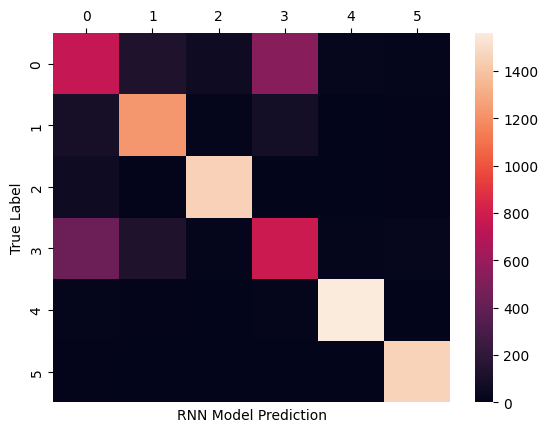

In [71]:
cm = confusion_matrix(preds, labels)
print(cm, '\n')
ax = sns.heatmap(cm)
ax.set(xlabel="RNN Model Prediction", ylabel="True Label")
ax.xaxis.tick_top()

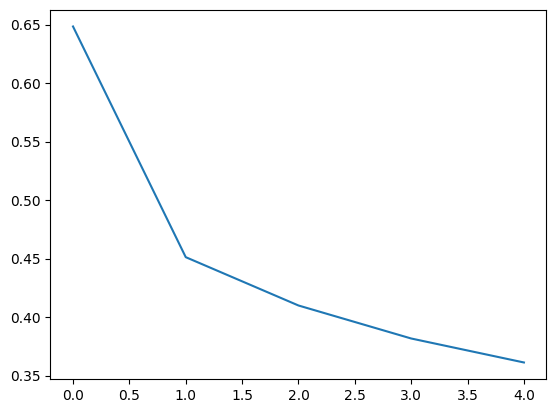

In [73]:
plt.plot(range(EPOCHS), total_training_loss)